In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import random
from sklearn.model_selection import train_test_split

In [8]:
images_path = '../../data/' # Ruta de las imagenes
classes = os.listdir(images_path) # Carpetas con cada label.
print(f'Clases : {classes}')

Clases : ['paper', 'rock', 'scissors']


In [9]:
images,label = [],[] # Genero 2 listas con la ruta relativa de la imagen incluida esta, y otra con los labeles,
for ind,clase in enumerate(classes):
    direccion = os.listdir(f'{images_path}{clase}')
    images += [f'{images_path}{clase}/{img}' for img in direccion]
    label += [ind]*len(direccion)
print(images)
print(label)

['../../data/paper/04l5I8TqdzF9WDMJ.png', '../../data/paper/0a3UtNzl5Ll3sq8K.png', '../../data/paper/0cb6cVL8pkfi4wF6.png', '../../data/paper/0eqArS2GgsBeqgSn.png', '../../data/paper/0Og76sl5CJhbxWWx.png', '../../data/paper/0RA9rcrv8iVvuDDU.png', '../../data/paper/0t08v9bAaA0mXGCQ.png', '../../data/paper/0Uomd0HvOB33m47I.png', '../../data/paper/0vugygEjxQJPr9yz.png', '../../data/paper/0zKU6wEhT2cDe9j0.png', '../../data/paper/14K62H4KG1hg5qiJ.png', '../../data/paper/1Dfw5FRlS4h60JPX.png', '../../data/paper/1fKclJk4eBWOQSR1.png', '../../data/paper/1Frbe8cdOdkciOBg.png', '../../data/paper/1jHtb93pI8f6pfKo.png', '../../data/paper/1oKnUgV2CdCaQUUX.png', '../../data/paper/1Tt9U9SzrOm98Xtw.png', '../../data/paper/1uoW7QcH2qAgCTxv.png', '../../data/paper/1yeoLbmp4alVOtFv.png', '../../data/paper/1yKjzquSvl9ShK7K.png', '../../data/paper/27XFtQjjXQ8AP8Tl.png', '../../data/paper/2DQbLQfHlfrcATqi.png', '../../data/paper/2F8Ng7620ANA7tEK.png', '../../data/paper/2IOsxsG8AaxntdJM.png', '../../data/pap

### Labels: 0  = Papel,  1 = Rock , 2 = Scissors

In [12]:
clases = {
    0: 'Papel',
    1:'Rock',
    2:'Scissors'
}

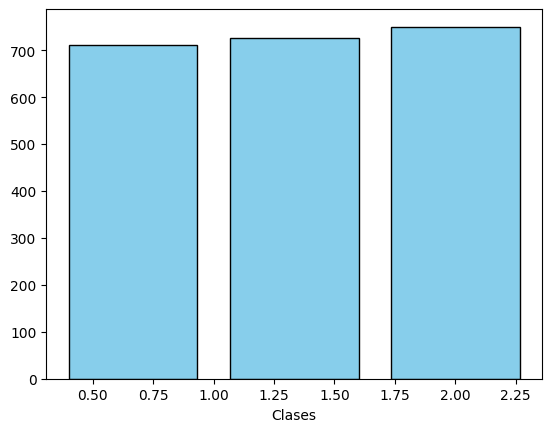

In [10]:
plt.hist(label,bins=3,align='right', rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Clases')
plt.show()

## Se puede observar una distribucion semejange entre las clases

## Voy a mostrar algunas imagenes

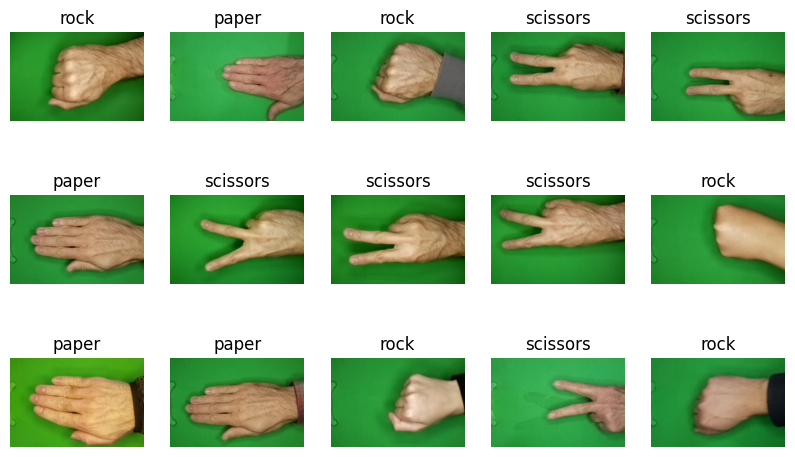

In [11]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(images)-1) # Genero un indice random para la lista de iamgenes
    img = io.imread(images[ix]) # Leo con imread a la imagen segun indice
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[label[ix]]) # Veo las clases con el indice
plt.show()

### Procedo a separar los datos en conjunto de entrenamiento y testeo


In [22]:
train_images, test_images, train_labels, test_labels = train_test_split(images, label, test_size=0.2, random_state=42)